# RecurrentTao - Generating Chinese Philosophy using RNNs
Advances in recurrent neural nets has enhanced the ability for machines to construct sentences by learning from reference material. This notebook applies these techniques on an english translation of Tao Te Ching - the famous philosophical text for Taoism. The book consists of 81 chapters of 5,000 characters in the native language, is much longer in the english variant and is less gramatically correct due to the direct translation of the text.

We explore a number of popular advances in the RNN space and how they work on sequence generation:
- Simple RNN: The basic RNN unit where hidden states receive information from observations and outputs from the previous hidden state
- Long Short Term Memory (LSTM): LSTM units consist of cells, input gates, output gates and forget gates. Storing information from many sequences ago and removing text which is no longer relevant addresses the long term dependencies of sequential data.
- Gated Recurrent Units (GRU): An RNN unit that controls the flow of information using reset and update gates. Filtering information and storing it into the next states has shown to help resolve the vanishing gradient problem. GRU's have been reported to be effective on small datasets.

In [2]:
# Standard libraries
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

## Data Preparation
The text is fairly clean but we will run a number of preprocessing methods before exploring the dataset first.

1. Loading the book as a long string.
2. Remove characters that are not letters or standard punctuation.
3. Produce a list of classes consisting of all the distinct characters after cleansing. This is required for encoding each character as numeric.

In [3]:
with open('taoteching.txt') as f:
    x = f.read()
    
print(x)

Tao Te Ching Chapter One Tao (The Way) that can be spoken of is not the Constant Tao’ The name that can be named is not a Constant Name. Nameless, is the origin of Heaven and Earth; The named is the Mother of all things. Thus, the constant void enables one to observe the true essence. The constant being enables one to see the outward manifestations. These two come paired from the same origin. But when the essence is manifested, It has a different name. This same origin is called “The Profound Mystery.” As profound the mystery as It can be, It is the Gate to the essence of all life. Chapter Two As soon as beauty is known by the world as beautiful, it becomes ugly. As soon as virtue is being known as something good, it becomes evil. Therefore being and non-being give birth to each other. Difficult and easy accomplish each other. Long and short form each other. High and low distinguish each other. Sound and tone harmonize each other Before and after follow each other as a sequence. Realiz

In [4]:
x = x.replace('\n', ' ')
x = x.replace('\r', ' ')
x = x.replace('  ', ' ')
x = x.lower()
import re

def cleaned_text(text):
    return re.sub("[^!,.:;? a-zA-Z]", "", text)

text = cleaned_text(x)

chars = sorted(list(set(text)))
print("this corpus has " + str(len(text)) + " total number of characters")
print("this corpus has " + str(len(chars)) + " unique characters")
print(chars)

this corpus has 54062 total number of characters
this corpus has 33 unique characters
[' ', '!', ',', '.', ':', ';', '?', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


## Exploratory Analysis
We can begin to visualize the types of words that feature in the text most frequently as insight to what words the RNN model might choose. We can start simple with an n-gram approach to model generation by randomly selecting subsequent words from a list of possible options derived from the text.

1. Generate frequencies of words.
2. Create frequencies of bigrams/trigrams/n-grams.
3. Build simple n-gram prediction model.
4. Generate sentences from this example.

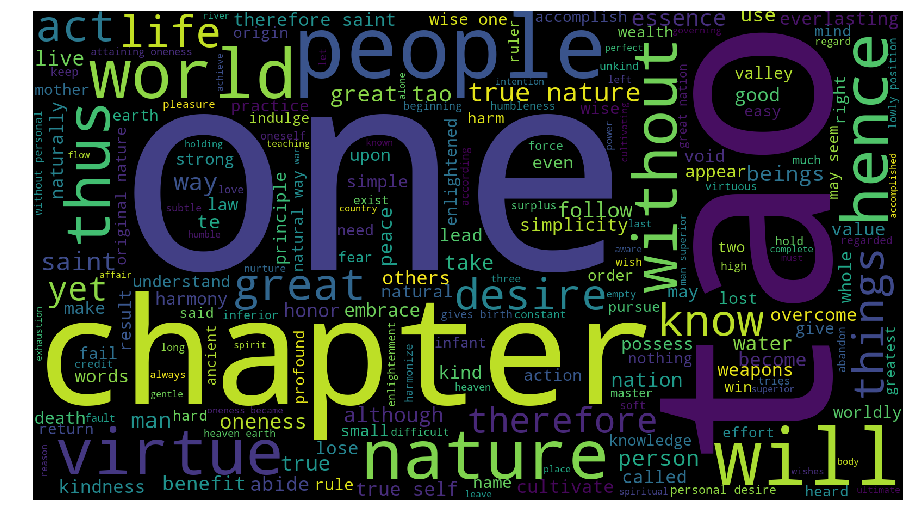

In [5]:
from wordcloud import WordCloud, STOPWORDS

wordcloud = WordCloud(width=1600, height=900, stopwords=STOPWORDS).generate(text)
plt.figure(figsize=(16,9))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [6]:
from collections import Counter

word_split = text.split(' ')
word_count = Counter(word_split)
word_df = pd.DataFrame([[k,v] for k,v in word_count.items()], columns=['word', 'frequency'])
non_stopwords = word_df.query('word not in @STOPWORDS')
non_stopwords.nlargest(100, columns = ['frequency'])

,word,frequency
144,one,113
159,chapter,81
1897,tao,81
1885,will,63
516,people,62
1753,true,57
467,great,54
1104,nature,53
833,ones,48
140,without,43


In [7]:
# Given a piece of text and n, construct the n-grams
def create_ngrams(text, n):
    word_split = text.split(' ')
    if n >= len(text):
        raise Exception('Sequence is too large.')
    grams = len(word_split) - n
    n_grams = [tuple(word_split[i:i+n]) for i in range(grams)]
    
    return n_grams

In [8]:
# Create bigrams and trigrams to see what sequences are common
bigrams = create_ngrams(text, 2)
trigrams = create_ngrams(text, 3)

bigram_counter = Counter(bigrams)
trigram_counter = Counter(trigrams)
bigram_counter.most_common(20)

[(('of', 'the'), 59),
 (('to', 'be'), 54),
 (('it', 'is'), 51),
 (('with', 'the'), 46),
 (('is', 'the'), 44),
 (('does', 'not'), 40),
 (('he', 'who'), 35),
 (('to', 'the'), 31),
 (('he', 'is'), 25),
 (('one', 'who'), 25),
 (('the', 'great'), 25),
 (('is', 'to'), 24),
 (('will', 'not'), 24),
 (('this', 'is'), 24),
 (('those', 'who'), 24),
 (('the', 'world'), 24),
 (('there', 'is'), 22),
 (('is', 'not'), 21),
 (('in', 'the'), 20),
 (('tao', 'is'), 20)]

In [9]:
from collections import defaultdict
import random

# Generate random sequences based on the grams
def create_transition(ngram):
    n = len(ngram[0])
    transitions = defaultdict(list)
    for gram in ngram:
        transitions[gram[:-1]].append(gram[-1])
    
    return transitions

# Generate sentences by using transitions
def generate_sentences(n, words, ngrams, transitions, words_to_generate=10):
    words = [*list(random.choice(ngrams))]
    
    for _ in range(words_to_generate):
        next_words = transitions[tuple(words[-n:])]
        if not next_words:
            next_word = random.choice(words)
            words.append(next_word)
        else:
            words.append(random.choice(next_words))
    
    print(' '.join(words))

bigram_transitions = create_transition(bigrams)
trigram_transitions = create_transition(trigrams)

# This doesn't work very well at all.
generate_sentences(2, word_split, bigrams, bigram_transitions)
generate_sentences(3, word_split, trigrams, trigram_transitions)

to be to be be be be be be to be to
fame and life, and fame life, and life, and life, life, and life,


## Preparing Sequence Windows

In [10]:
def windowFunction(text, window_size = 2, step_size = 2):
    steps = (len(text) - window_size) // step_size
    input_window = [text[(i*step_size):(i*step_size)+window_size] for i in range(steps)]
    output_window = [text[(i*step_size)+window_size] for i in range(steps)]
    
    return input_window, output_window

In [11]:
X, y = windowFunction(text, 20)

print("input:", X[11])
print("output:", y[11])
print('-------------')
print("input:", X[100])
print("output:", y[100])

input: ne tao the way that 
output: c
-------------
input: er of all things. th
output: u


In [12]:
chars_to_indices = dict((c, i) for i, c in enumerate(chars))
indices_to_chars = dict((i, c) for i, c in enumerate(chars))

In [13]:
# transform characters to numerical versions
def encode_io_pairs(text, window_size, step_size):
    input_seq, output_seq = windowFunction(text, window_size, step_size)
    
    X = np.zeros(shape=(len(input_seq), window_size, len(chars_to_indices)), dtype=np.bool)
    y = np.zeros(shape=(len(output_seq), len(chars_to_indices)))
    
    for i, sentence in enumerate(input_seq):
        for t, char in enumerate(sentence):
            X[i,t,chars_to_indices[char]] = 1
        y[i, chars_to_indices[output_seq[i]]] = 1
        
    return X, y

In [14]:
window_size = 100
step_size = 1

X, y = encode_io_pairs(text, window_size, step_size)
print(X.shape)
print(y.shape)

(53962, 100, 33)
(53962, 33)


## Single Layer LSTM

In [15]:
from keras.models import Sequential
from keras.layers import Dense, Activation, LSTM
from keras.optimizers import RMSprop
from keras.utils.data_utils import get_file
import keras
import random

Using TensorFlow backend.


In [16]:
def build_model(recurrent, units):
    model = Sequential()
    model.add(recurrent(units, input_shape = (window_size, len(chars))))
    model.add(Dense(len(chars)))
    model.add(Activation(activation='softmax'))
    
    return model

lstm_model = build_model(LSTM, 200)

optimizer = keras.optimizers.RMSprop(lr=0.001, rho = 0.9, epsilon=1e-08, decay=0)
lstm_model.compile(loss='categorical_crossentropy', optimizer = optimizer, metrics = ['acc'])

In [18]:
Xsmall = X[:10000,:,:]
ysmall = y[:10000,:]

lstm_model.fit(Xsmall, ysmall, batch_size=1024, epochs=40, verbose=1)
lstm_model.save_weights('best_RNN_small.hdf5')

Epoch 1/40
10000/10000 [==============================] - 3s - loss: 1.6740 - acc: 0.5059     
Epoch 2/40
10000/10000 [==============================] - 3s - loss: 1.6486 - acc: 0.5105     
Epoch 3/40
10000/10000 [==============================] - 3s - loss: 1.6138 - acc: 0.5219     
Epoch 4/40
10000/10000 [==============================] - 3s - loss: 1.5950 - acc: 0.5263     
Epoch 5/40
10000/10000 [==============================] - 3s - loss: 1.5678 - acc: 0.5318     
Epoch 6/40
10000/10000 [==============================] - 3s - loss: 1.5512 - acc: 0.5388     
Epoch 7/40
10000/10000 [==============================] - 3s - loss: 1.5310 - acc: 0.5459     
Epoch 8/40
10000/10000 [==============================] - 3s - loss: 1.4995 - acc: 0.5557     
Epoch 9/40
10000/10000 [==============================] - 3s - loss: 1.4813 - acc: 0.5619     
Epoch 10/40
10000/10000 [==============================] - 3s - loss: 1.4588 - acc: 0.5678     
Epoch 11/40
10000/10000 [========================

In [17]:
# Given an input sequence, predict the next number of characters using the trained RNN model.
def predict_next_chars(model, input_chars, num_to_predict):
    predicted_chars = ''
    for i in range(num_to_predict):
        x_test = np.zeros((1, window_size, len(chars)))
        for t, char in enumerate(input_chars):
            x_test[0, t, chars_to_indices[char]] = 1
        
        test_predict = model.predict(x_test, verbose = 0)[0]
        
        r = np.argmax(test_predict)
        d = indices_to_chars[r]
        
        predicted_chars += d
        input_chars += d
        input_chars = input_chars[1:]
    return predicted_chars            

In [18]:
start_inds = [100, 200, 300, 400, 500]
lstm_model.load_weights('best_RNN_small.hdf5')

# Given an array of start indices from the text and a model, print out all the predicted sequences
def predict_sequences(model, start_inds):
    for s in start_inds:
        start_index = s
        input_chars = text[start_index:start_index + window_size]
        predict_input = predict_next_chars(model, input_chars, num_to_predict = 100)
        
        print('-------------------')
        input_line = 'input chars = "' + input_chars + '"'
        print(input_line)
        line = 'predicted chars = "' + predict_input + '"'
        print(line)
        
predict_sequences(lstm_model, start_inds)

-------------------
input chars = " be named is not a constant name. nameless, is the origin of heaven and earth; the named is the moth"
predicted chars = "er one to erter. chapter ther enentunane s archist of the mystic taoune wale soncoust of the mord is"
-------------------
input chars = "er of all things. thus, the constant void enables one to observe the true essence. the constant bein"
predicted chars = "g enables one to ses reao. the eapte seact of the misterion all things without the ores not calles t"
-------------------
input chars = "g enables one to see the outward manifestations. these two come paired from the same origin. but whe"
predicted chars = "n the essence of the sulle is the mayter in the resert of the misterion all things without the ores "
-------------------
input chars = "n the essence is manifested, it has a different name. this same origin is called the profound myster"
predicted chars = "y gover and furce. the gave to sherf call the mastingion. a harsone th

In [21]:
# Fit the LSTM model on the entire dataset.
lstm_model.fit(X, y, batch_size = 1024, epochs = 40, verbose = 1)
lstm_model.save_weights('best_RNN_full.hdf5')

Epoch 1/40
53962/53962 [==============================] - 20s - loss: 1.5997 - acc: 0.5338    
Epoch 2/40
53962/53962 [==============================] - 19s - loss: 1.4968 - acc: 0.5584    
Epoch 3/40
53962/53962 [==============================] - 19s - loss: 1.4455 - acc: 0.5746    
Epoch 4/40
53962/53962 [==============================] - 19s - loss: 1.4070 - acc: 0.5859    
Epoch 5/40
53962/53962 [==============================] - 19s - loss: 1.3731 - acc: 0.5956    
Epoch 6/40
53962/53962 [==============================] - 19s - loss: 1.3411 - acc: 0.6055    
Epoch 7/40
53962/53962 [==============================] - 19s - loss: 1.3114 - acc: 0.6153    
Epoch 8/40
53962/53962 [==============================] - 19s - loss: 1.2841 - acc: 0.6245    
Epoch 9/40
53962/53962 [==============================] - 19s - loss: 1.2556 - acc: 0.6322    
Epoch 10/40
53962/53962 [==============================] - 20s - loss: 1.2268 - acc: 0.6419    
Epoch 11/40
53962/53962 [========================

In [24]:
start_inds = [100, 200, 300, 400, 500]
f = open('RNN_output.txt', 'w')

lstm_model.load_weights('best_RNN_full.hdf5')
predict_sequences(lstm_model, start_inds)

-------------------
input chars = " be named is not a constant name. nameless, is the origin of heaven and earth; the named is the moth"
predicted chars = "er of all things. therefore, the greate the great is calling and the surtle of tao. chapter thirtysi"
-------------------
input chars = "er of all things. thus, the constant void enables one to observe the true essence. the constant bein"
predicted chars = "g enables one to see the outhalt as are fullound. therefore, the saint a waids and shall wis the tao"
-------------------
input chars = "g enables one to see the outward manifestations. these two come paired from the same origin. but whe"
predicted chars = "n the essence is sumplientian ones endies take be the fealor. the sait form with the sult rate to be"
-------------------
input chars = "n the essence is manifested, it has a different name. this same origin is called the profound myster"
predicted chars = "y. a man of superior virtue, a person of nature without desire while h

## GRU Variant

In [17]:
from keras.layers import GRU, SimpleRNN

# Train the equivalent model but using a Gated Recurrent Unit instead
gru_model = build_model(GRU, 200)
optimizer = keras.optimizers.RMSprop(lr=0.001, rho = 0.9, epsilon=1e-08, decay=0)
gru_model.compile(loss='categorical_crossentropy', optimizer = optimizer, metrics = ['acc'])
gru_model.fit(X, y, batch_size=1024, epochs=40, verbose=1)
gru_model.save_weights('gru_rnn.hdf5')

Epoch 1/40
53962/53962 [==============================] - 16s - loss: 2.9531 - acc: 0.1931    
Epoch 2/40
53962/53962 [==============================] - 15s - loss: 2.5534 - acc: 0.2945    
Epoch 3/40
53962/53962 [==============================] - 15s - loss: 2.3341 - acc: 0.3374    
Epoch 4/40
53962/53962 [==============================] - 15s - loss: 2.1898 - acc: 0.3670    
Epoch 5/40
53962/53962 [==============================] - 15s - loss: 2.0948 - acc: 0.3911    
Epoch 6/40
53962/53962 [==============================] - 15s - loss: 2.0180 - acc: 0.4095    
Epoch 7/40
53962/53962 [==============================] - 15s - loss: 1.9539 - acc: 0.4262    
Epoch 8/40
53962/53962 [==============================] - 15s - loss: 1.8983 - acc: 0.4402    
Epoch 9/40
53962/53962 [==============================] - 15s - loss: 1.8480 - acc: 0.4554    
Epoch 10/40
53962/53962 [==============================] - 15s - loss: 1.8021 - acc: 0.4699    
Epoch 11/40
53962/53962 [========================

In [21]:
# Load GRU model weights and try predicting the sequences
gru_model.load_weights('gru_rnn.hdf5')
predict_sequences(gru_model, start_inds)

-------------------
input chars = " be named is not a constant name. nameless, is the origin of heaven and earth; the named is the moth"
predicted chars = "er of tao is because the eneress and the nature of the nature of the nature. the tao of nature is to"
-------------------
input chars = "er of all things. thus, the constant void enables one to observe the true essence. the constant bein"
predicted chars = "g exhausted. there is no reserve the serred ones eryon. the saint altheag that is a searnes the east"
-------------------
input chars = "g enables one to see the outward manifestations. these two come paired from the same origin. but whe"
predicted chars = "n the empty stact profound and distrace the oneness that is some and deale, because the enemented an"
-------------------
input chars = "n the essence is manifested, it has a different name. this same origin is called the profound myster"
predicted chars = " it can be reperied and shall not be hence, the eastry the people are 

## Simple RNN Variant

In [22]:
rnn_model = build_model(SimpleRNN, 200)
optimizer = keras.optimizers.RMSprop(lr=0.001, rho = 0.9, epsilon=1e-08, decay=0)
rnn_model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['acc'])
rnn_model.fit(X, y, batch_size= 1024, epochs=40, verbose=1)
rnn_model.save_weights('simple_rnn.hdf5')

Epoch 1/40
53962/53962 [==============================] - 4s - loss: 2.8108 - acc: 0.2047     
Epoch 2/40
53962/53962 [==============================] - 4s - loss: 2.4799 - acc: 0.3095     
Epoch 3/40
53962/53962 [==============================] - 4s - loss: 2.2903 - acc: 0.3561     
Epoch 4/40
53962/53962 [==============================] - 4s - loss: 2.1691 - acc: 0.3809     
Epoch 5/40
53962/53962 [==============================] - 4s - loss: 2.0950 - acc: 0.3926     
Epoch 6/40
53962/53962 [==============================] - 4s - loss: 2.0401 - acc: 0.4074     
Epoch 7/40
53962/53962 [==============================] - 4s - loss: 2.0006 - acc: 0.4154     
Epoch 8/40
53962/53962 [==============================] - 4s - loss: 1.9648 - acc: 0.4252     
Epoch 9/40
53962/53962 [==============================] - 4s - loss: 1.9348 - acc: 0.4330     
Epoch 10/40
53962/53962 [==============================] - 4s - loss: 1.9063 - acc: 0.4403     
Epoch 11/40
53962/53962 [========================

In [23]:
# Load Simple model weights and try predicting the sequences
rnn_model.load_weights('simple_rnn.hdf5')
predict_sequences(rnn_model, start_inds)

-------------------
input chars = " be named is not a constant name. nameless, is the origin of heaven and earth; the named is the moth"
predicted chars = "er and bedses not one is is becamed the trees the sorte tao is will be not in the relene shes with t"
-------------------
input chars = "er of all things. thus, the constant void enables one to observe the true essence. the constant bein"
predicted chars = "g in the and eres at one who ho sendes soll with the reginn of the world. chapter firtyfine whe rous"
-------------------
input chars = "g enables one to see the outward manifestations. these two come paired from the same origin. but whe"
predicted chars = " the serighe the ralise the word to rele sing the will not be and deast. he who is as are condit of "
-------------------
input chars = "n the essence is manifested, it has a different name. this same origin is called the profound myster"
predicted chars = " the great tao. chapter firtyfive and the seact at and there is the wi

## Multilayer LSTM

In [19]:
from keras.layers import TimeDistributed, LSTM, BatchNormalization, Input
from keras.models import Model

def multilayer_rnn(recurrent, units, layers):    
    model = Sequential()
    model.add(recurrent(units, input_shape=(window_size, len(chars)), return_sequences=True, name='rnn_layer0'))
    model.add(BatchNormalization(name='bn_0'))
    for i in range(layers-2):
        model.add(recurrent(units, return_sequences=True, name='rnn_layer{}'.format(i+1)))
        model.add(BatchNormalization(name='bn_{}'.format(i+1)))
    
    model.add(recurrent(units, return_sequences=False, name = 'rnn_layer{}'.format(layers)))  
    model.add(Dense(len(chars), name='dense'))
    model.add(Activation('softmax', name='softmax'))
    
    return model

multi_lstm = multilayer_rnn(LSTM, 200, 2)
optimizer = keras.optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0)
multi_lstm.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics = ['acc'])
multi_lstm.fit(X, y, batch_size=2048, epochs=40, verbose=1)
multi_lstm.save_weights('multi_lstm.hdf5')

Epoch 1/40
53962/53962 [==============================] - 39s - loss: 2.8844 - acc: 0.1888    
Epoch 2/40
53962/53962 [==============================] - 39s - loss: 2.3822 - acc: 0.3211    
Epoch 3/40
53962/53962 [==============================] - 39s - loss: 2.1092 - acc: 0.3855    
Epoch 4/40
53962/53962 [==============================] - 39s - loss: 1.9256 - acc: 0.4362    
Epoch 5/40
53962/53962 [==============================] - 39s - loss: 1.7885 - acc: 0.4728    
Epoch 6/40
53962/53962 [==============================] - 40s - loss: 1.6793 - acc: 0.5076    
Epoch 7/40
53962/53962 [==============================] - 40s - loss: 1.5879 - acc: 0.5357    
Epoch 8/40
53962/53962 [==============================] - 40s - loss: 1.5175 - acc: 0.5572    
Epoch 9/40
53962/53962 [==============================] - 40s - loss: 1.4521 - acc: 0.5771    
Epoch 10/40
53962/53962 [==============================] - 40s - loss: 1.3990 - acc: 0.5905    
Epoch 11/40
53962/53962 [========================

In [20]:
multi_lstm.load_weights('multi_lstm.hdf5')
predict_sequences(multi_lstm, start_inds)

-------------------
input chars = " be named is not a constant name. nameless, is the origin of heaven and earth; the named is the moth"
predicted chars = "er of all things and shall lose his the exesse tone as one who seek will not enlighten one other sha"
-------------------
input chars = "er of all things. thus, the constant void enables one to observe the true essence. the constant bein"
predicted chars = "g for acts achieve harmony. the the sold others for he is no natural eash. thus, a saint is the flow"
-------------------
input chars = "g enables one to see the outward manifestations. these two come paired from the same origin. but whe"
predicted chars = " heaven and earth is the execustive as no wer such attranquile its fould and shall not be confused. "
-------------------
input chars = "n the essence is manifested, it has a different name. this same origin is called the profound myster"
predicted chars = "y. a man of strong enlighteen ones true nature with surplus its for th